In [1]:
try:
    if manager == 1:
        print("Manager Mode: ON")
except:
    print("Manager Mode: OFF")
    %run s0_config.ipynb
    import scanpy as sc
    import numpy as np
    import pandas as pd
adata = sc.read(check_point_s2)


Manager Mode: OFF


/Users/mac/Documents/Thesis/exp1/bilimnn/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.10.1 anndata==0.10.7 umap==0.5.6 numpy==1.26.4 scipy==1.13.1 pandas==2.2.2 scikit-learn==1.5.0 statsmodels==0.14.2 igraph==0.11.5 pynndescent==0.5.12


In [2]:

# Function to Calculate Resolutions
def calculate_resolutions(adata, method="pca", true_label="cell_type", start_res=0.1, jump_res=0.01):
    target_cluster = pd.unique(adata.obs[true_label])
    resolutions = np.arange(start_res, 5, jump_res)
    n_clusters = []
    n_dict = {}
    threshold = 0

    for res in resolutions:
        res_key = f"leiden_{method}_{str(float(np.round(res,3)))}"
        print("res_key:", res_key)
        sc.tl.leiden(adata, key_added=res_key, resolution=res)
        n_clusters.append(adata.obs[res_key].nunique())
        n_dict[res_key] = res
        if adata.obs[res_key].nunique() >= len(target_cluster):
            if threshold == 0:
                break
    return adata, n_dict

computing PCA
    with n_comps=50
    finished (0:00:10)


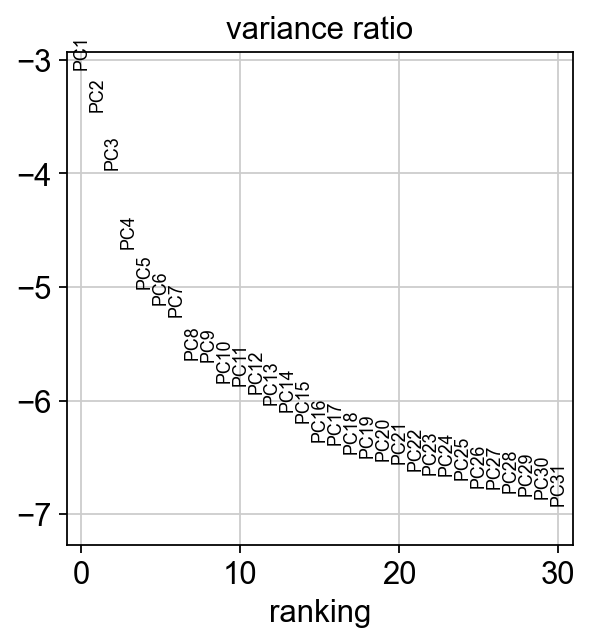

computing neighbors


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:13)
res_key: leiden_pca_0.15
running Leiden clustering


/var/folders/bv/gw05vsj97hbdv_zh2q8yqd7h0000gn/T/ipykernel_47409/2519928442.py:12: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, key_added=res_key, resolution=res)


    finished: found 18 clusters and added
    'leiden_pca_0.15', the cluster labels (adata.obs, categorical) (0:00:07)


IndexError: list index out of range

In [3]:

# Preprocessing
adata.obs['cell_type_short'] = adata.obs['cell_type'].str[:8]
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50, use_rep='X_pca')

# Calculate Resolutions
adata, n_dict_pca = calculate_resolutions(adata, method="pca", true_label="cell_type", start_res=0.15, jump_res=0.01)
best_pca = list(n_dict_pca.keys())[-2]
current_key = best_pca


In [ ]:

# Calculate Metrics
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.metrics.cluster import contingency_matrix

silhouette_avg = silhouette_score(adata.obsm['X_pca'], adata.obs[current_key])
print("Silhouette Score: ", silhouette_avg)

ari = adjusted_rand_score(adata.obs['cell_type'], adata.obs[current_key])
print("Adjusted Rand Index: ", ari)

cm = contingency_matrix(adata.obs['cell_type'], adata.obs[current_key])
purity = np.sum(np.amax(cm, axis=0)) / np.sum(cm)
print("Cluster Purity: ", purity)

# Store Results
results = {
    'resolution': n_dict_pca[best_pca],
    'silhouette_score': silhouette_avg,
    'ari': ari,
    'purity': purity
}


In [ ]:

# Iterate for Different Versions
all_results = []
for i in range(10):
    # Adjust starting resolution and jump for variation
    start_res = 0.1 + i * 0.05
    jump_res = 0.01 + i * 0.001
    adata, n_dict_pca = calculate_resolutions(adata, method="pca", true_label="cell_type", start_res=start_res, jump_res=jump_res)
    best_pca = list(n_dict_pca.keys())[-2]
    current_key = best_pca

    silhouette_avg = silhouette_score(adata.obsm['X_pca'], adata.obs[current_key])
    ari = adjusted_rand_score(adata.obs['cell_type'], adata.obs[current_key])
    cm = contingency_matrix(adata.obs['cell_type'], adata.obs[current_key])
    purity = np.sum(np.amax(cm, axis=0)) / np.sum(cm)

    results = {
        'version': i+1,
        'resolution': n_dict_pca[best_pca],
        'silhouette_score': silhouette_avg,
        'ari': ari,
        'purity': purity
    }
    all_results.append(results)
    print(f"Version {i+1} completed")

# Save Results
import json
with open('results.json', 'w') as f:
    json.dump(all_results, f)

print("All results saved to results.json")

scanpy==1.10.1 anndata==0.10.7 umap==0.5.6 numpy==1.26.4 scipy==1.13.1 pandas==2.2.2 scikit-learn==1.5.0 statsmodels==0.14.2 igraph==0.11.5 pynndescent==0.5.12


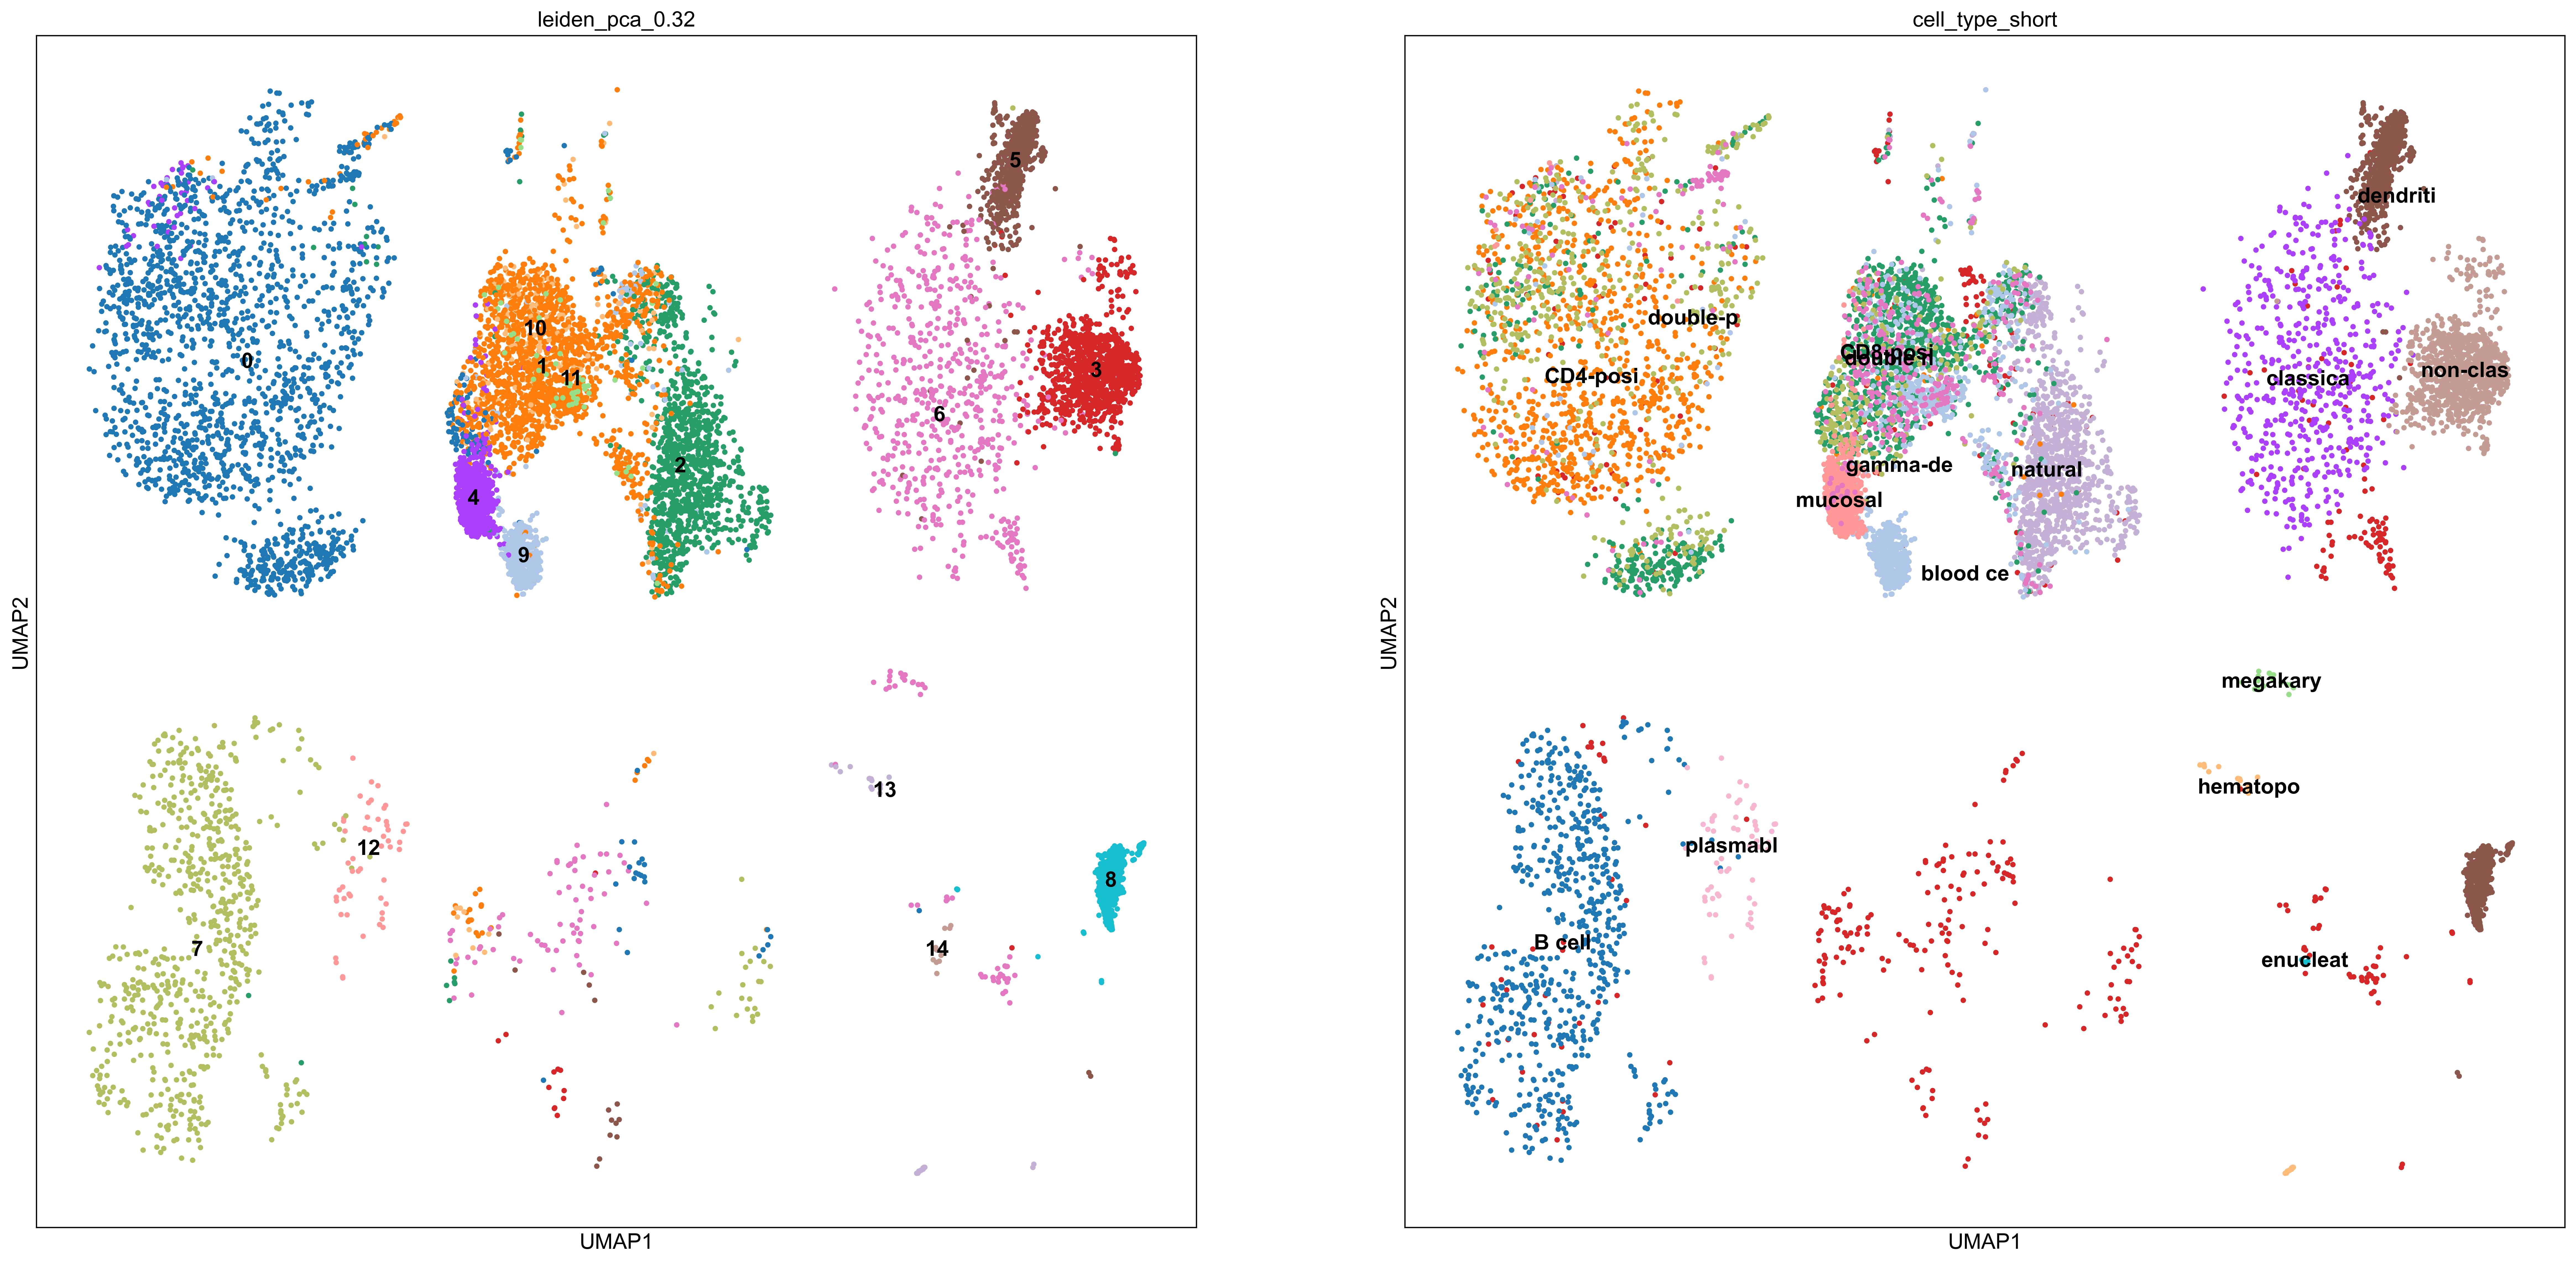

Number of clusters in selected cluster key leiden_pca_0.32: 15


In [ ]:
sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=200, facecolor="white", figsize=(14, 14))
sc.pl.umap(adata, color=[current_key, "cell_type_short"], legend_loc="on data", title=[current_key, "cell_type_short"], frameon=True, size=50)
print(f"Number of clusters in selected cluster key {current_key}: {adata.obs[current_key].nunique()}")


In [ ]:
from sklearn.decomposition import FastICA
ica = FastICA(n_components=20, random_state=0)
ica_result = ica.fit_transform(adata.X.toarray() if hasattr(adata.X, 'toarray') else adata.X)
adata.obsm['X_ica'] = ica_result
sc.pp.neighbors(adata, use_rep='X_ica')
adata, n_dict_ica = calculate_resolutions(adata, method="ica", true_label="cell_type", start_res=0.5, jump_res=0.01)
try:
    best_ica = list(n_dict_ica.keys())[-2]
    current_key = best_ica
except:
    current_key = list(n_dict_ica.keys())[0]


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
res_key: leiden_ica_0.5
running Leiden clustering
    finished: found 16 clusters and added
    'leiden_ica_0.5', the cluster labels (adata.obs, categorical) (0:00:02)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

input_dim = adata.X.shape[1]
encoding_dim = 50

input_layer = layers.Input(shape=(input_dim,))
encoder = layers.Dense(encoding_dim, activation="relu")(input_layer)
decoder = layers.Dense(input_dim, activation="sigmoid")(encoder)

autoencoder = tf.keras.Model(input_layer, decoder)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(adata.X, adata.X, epochs=50, batch_size=256, shuffle=True, validation_split=0.2)

encoder_model = tf.keras.Model(input_layer, encoder)
encoded_data = encoder_model.predict(adata.X)
adata.obsm["X_autoencoder"] = encoded_data

sc.pp.neighbors(adata, use_rep='X_autoencoder')
adata, n_dict_autoencoder = calculate_resolutions(adata, method="autoencoder", true_label="cell_type", start_res=0.95, jump_res=0.01)
best_autoencoder = list(n_dict_autoencoder.keys())[-3]
current_key = best_autoencoder


Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.0039 - val_loss: 0.7354
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8021 - val_loss: 0.7131
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7867 - val_loss: 0.7088
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7815 - val_loss: 0.7072
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7774 - val_loss: 0.7050
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7719 - val_loss: 0.7029
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7735 - val_loss: 0.7007
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7729 - val_loss: 0.6986
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7687 - val_loss: 0.6966
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7666 - val_loss: 0.6942
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7695 - val_loss: 0.6924
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7609 - val_lo

In [ ]:
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import regularizers

scaler = StandardScaler()
pca_data_normalized = scaler.fit_transform(adata.obsm['X_pca'][:, :30])

input_dim = pca_data_normalized.shape[1]
encoding_dim = 50

input_layer = layers.Input(shape=(input_dim,))
encoder = layers.Dense(encoding_dim, activation="relu", activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = layers.Dense(encoding_dim // 2, activation="relu")(encoder)
decoder = layers.Dense(input_dim, activation="sigmoid")(encoder)

autoencoder = tf.keras.Model(input_layer, decoder)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(pca_data_normalized, pca_data_normalized, epochs=200, batch_size=256, shuffle=True, validation_split=0.2)

encoder_model = tf.keras.Model(input_layer, encoder)
encoded_data = encoder_model.predict(pca_data_normalized)
adata.obsm["X_combined"] = encoded_data

adata, n_dict_combined = calculate_resolutions(adata, method="combined", true_label="cell_type", start_res=0.32, jump_res=0.1)
best_combined = list(n_dict_combined.keys())[-2]
current_key = best_combined


Epoch 1/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6505 - val_loss: 1.4900
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4686 - val_loss: 1.3746
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3458 - val_loss: 1.3049
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - loss: 1.2296 - val_loss: 1.2567
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step - loss: 1.1661 - val_loss: 1.2090
Epoch 6/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - loss: 1.1133 - val_loss: 1.1624
Epoch 7/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step - loss: 1.0802 - val_loss: 1.1207
Epoch 8/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - loss: 1.0870 - val_loss: 1.0867
Epoch 9/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step - loss: 1.0469 - val_loss: 1.0594
Epoch 10/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step - loss: 1.0211 - val_loss: 1.0396
Epoch 11/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - loss: 1.0331 - val_loss: 1.0257
Epoch 12/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 877u

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics.cluster import contingency_matrix

silhouette_avg = silhouette_score(adata.obsm['X_combined'], adata.obs[current_key])
print("Silhouette Score: ", silhouette_avg)

ari = adjusted_rand_score(adata.obs['cell_type'], adata.obs[current_key])
print("Adjusted Rand Index: ", ari)

cm = contingency_matrix(adata.obs['cell_type'], adata.obs[current_key])
purity = np.sum(np.amax(cm, axis=0)) / np.sum(cm)
print("Cluster Purity: ", purity)


Silhouette Score:  0.10472443
Adjusted Rand Index:  0.5064756572425424
Cluster Purity:  0.686347587289133
